# EfficientNet

En este notebook, se desarrolla el entrenamiento y predicción del modelo EfficientNet para la detección de insectos en fotografías de plantas, destinado a generar una red de polinizadores.

## Paquetes

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from efficientnet.keras import center_crop_and_resize, preprocess_input
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.imagenet_utils import decode_predictions
from sklearn.metrics import confusion_matrix

import numpy as np
from skimage.io import imread
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

Realizamos la lectura de los datos.

In [53]:
base_dir = ''
train_dir = base_dir + 'dataset/images/train'
val_dir = base_dir + 'dataset/images/val'
data = pd.read_csv(base_dir + 'dataset/info_imagenes_cat.csv')
# Quito las columnas que no me sirven
data = data.drop(['xmin', 'xmax', 'ymin', 'ymax'], axis=1)
# Cambio categoría a string
data['categoría'] = data['categoría'].astype(str)
# Agrego la categoría a la ruta de la imagen
data['imagen'] = 'dataset/' + data['categoría'] + '/' + data['imagen']

# Tomo una muestra equilibrada por categoría
data_train = data.groupby('categoría').sample(230, random_state=1)
# Tomo data menos data_train
test = data.drop(data_train.index)
data_train = data_train.reset_index(drop=True)
test = test.reset_index(drop=True)
# Divido en train y val a un 80% equilibrado
train = data_train.groupby('categoría').sample(frac=0.8, random_state=1)
val = data_train.drop(train.index)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
# Reviso
display(val.head(2))
# Cantidades
print('Cantidad de datos de entrenamiento:', len(train))
print('Cantidad de datos de validación:', len(val))
print('Cantidad de datos de testeo:', len(test))


,imagen,categoría
0,dataset/0/8mp_130520_14_08_30_684136.jpg,0
1,dataset/0/fa926d658d1b9a9e39d4b16ee649b2a3.jpg,0


Cantidad de datos de entrenamiento: 1288
Cantidad de datos de validación: 322
Cantidad de datos de testeo: 1805


Se dividen los datos en entrenamiento y validación.

In [56]:
train_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    x_col="imagen",
    y_col="categoría",
    target_size=(600, 600),
    batch_size=32
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe = val,
    x_col="imagen",
    y_col="categoría",
    target_size=(600, 600),
    batch_size=32
)

Found 1273 validated image filenames belonging to 7 classes.
Found 316 validated image filenames belonging to 7 classes.


c:\Users\aemer\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 15 invalid image filename(s) in x_col="imagen". These filename(s) will be ignored.
  warnings.warn(
c:\Users\aemer\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 6 invalid image filename(s) in x_col="imagen". These filename(s) will be ignored.
  warnings.warn(


## Revisión del modelo sin entrenar

Cargamos el modelo base de EfficientNet, entrenado con el dataset imagenet, sin entrenar, para ver como se comporta con imágenes de nuestro dataset.

In [67]:
# loading pretrained model
model = EfficientNetB7(weights='imagenet')
image_size = model.input_shape[1]

In [68]:
# Recorro las imágenes de validación
detecciones = []
images = os.listdir('dataset/images/test')
for img in images:
    image = imread('dataset/images/test/' + img)
    x = center_crop_and_resize(image, image_size=image_size)
    x = preprocess_input(x)
    x = np.expand_dims(x, 0)
    y = model.predict(x)
    detection = decode_predictions(y)[0][0][1]
    detecciones.append(detection)

# Genero el dataframe con las imagenes y las detecciones
df = pd.DataFrame({'imagen': images, 'deteccion': detecciones})
# Reviso
display(df.head(5))

1/1 [==============================] - 0s 47ms/step


,imagen,deteccion
0,00068ee5e4632cf05be16306f00aa51b.jpg,matchstick
1,0065808ec8a40acb4dbaf1a855045a1b.jpg,matchstick
2,00720ef5141a225e95a973c785e5292b.jpg,jack-o'-lantern
3,00ad5ae0ef6fe82cad95e54e8f478857.jpg,nematode
4,00ad5ae0ef6fe82cad95e54e8f478857_reflejada1.jpg,nematode


Realizamos un conteo de las predicciones.

In [69]:
# Conteo de detecciones
df['deteccion'].value_counts()

matchstick            779
jack-o'-lantern       233
nematode              181
daisy                  80
abaya                  66
spotlight              54
velvet                 49
feather_boa            31
candle                 22
sea_urchin             21
barn_spider            19
jellyfish              16
sea_anemone             8
digital_clock           8
umbrella                7
cloak                   6
theater_curtain         5
Egyptian_cat            5
lampshade               5
lacewing                4
pick                    4
cockroach               3
harvestman              3
groenendael             3
chambered_nautilus      2
weasel                  2
mushroom                2
hare                    2
suit                    2
quill                   2
coil                    1
trench_coat             1
radio_telescope         1
wood_rabbit             1
microphone              1
chainlink_fence         1
cricket                 1
affenpinscher           1
tennis_ball 

## Entrenamiento del modelo

Entrenamos el modelo EfficientNet, durante 50 épocas.

In [70]:
base_model = EfficientNetB7(
    weights='imagenet',
    input_shape=(600,600,3),
    include_top=False,
    pooling='max'
)
base_model.trainable = False  # Congelar el modelo base

model = Sequential()
model.add(base_model)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 7, activation='softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 dense_6 (Dense)             (None, 120)               307320    
                                                                 
 dense_7 (Dense)             (None, 120)               14520     
                                                                 
 dense_8 (Dense)             (None, 7)                 847       
                                                                 
Total params: 64,420,374
Trainable params: 322,687
Non-trainable params: 64,097,687
_________________________________________________________________


In [71]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs = 50,
    steps_per_epoch = 15,
    validation_data = val_generator,
    validation_steps = 7
)


Epoch 1/50
15/15 [==============================] - 50s 3s/step - loss: 3.6178 - accuracy: 0.1271 - val_loss: 2.4290 - val_accuracy: 0.1295
Epoch 2/50
15/15 [==============================] - 36s 2s/step - loss: 2.2553 - accuracy: 0.1479 - val_loss: 1.9932 - val_accuracy: 0.1429
Epoch 3/50
15/15 [==============================] - 36s 2s/step - loss: 2.0555 - accuracy: 0.1628 - val_loss: 2.2953 - val_accuracy: 0.1473
Epoch 4/50
15/15 [==============================] - 37s 3s/step - loss: 2.2844 - accuracy: 0.1268 - val_loss: 2.4460 - val_accuracy: 0.1473
Epoch 5/50
15/15 [==============================] - 37s 2s/step - loss: 2.2705 - accuracy: 0.1353 - val_loss: 2.2305 - val_accuracy: 0.1562
Epoch 6/50
15/15 [==============================] - 37s 3s/step - loss: 2.1690 - accuracy: 0.1375 - val_loss: 2.0848 - val_accuracy: 0.1562
Epoch 7/50
15/15 [==============================] - 37s 3s/step - loss: 2.0939 - accuracy: 0.1437 - val_loss: 2.2435 - val_accuracy: 0.1205
Epoch 8/50
15/15 [==

Revisamos la historia del entrenamiento.

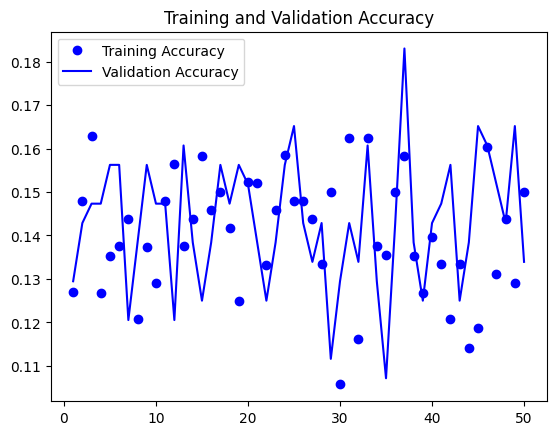

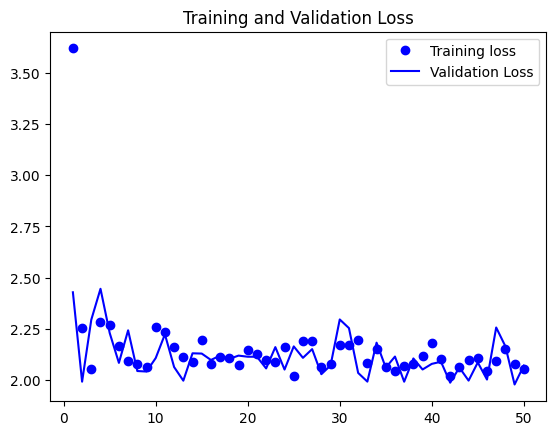

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Guardamos los pesos del modelo.

In [73]:
#saving the trained model weights as data file in .h5 format
model.save_weights("efficientnetb7_weights.h5")

## Modelo entrenado

Usamos el modelo entrenado con el dataser de plantas e insectos.

In [74]:
test_dir = base_dir + 'dataset/images/test'

test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    x_col="imagen",
    y_col="categoría",
    target_size=(600, 600),
    batch_size=32
)

Found 1733 validated image filenames belonging to 7 classes.


c:\Users\aemer\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 72 invalid image filename(s) in x_col="imagen". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)

Elaboramos la matriz de confusión.

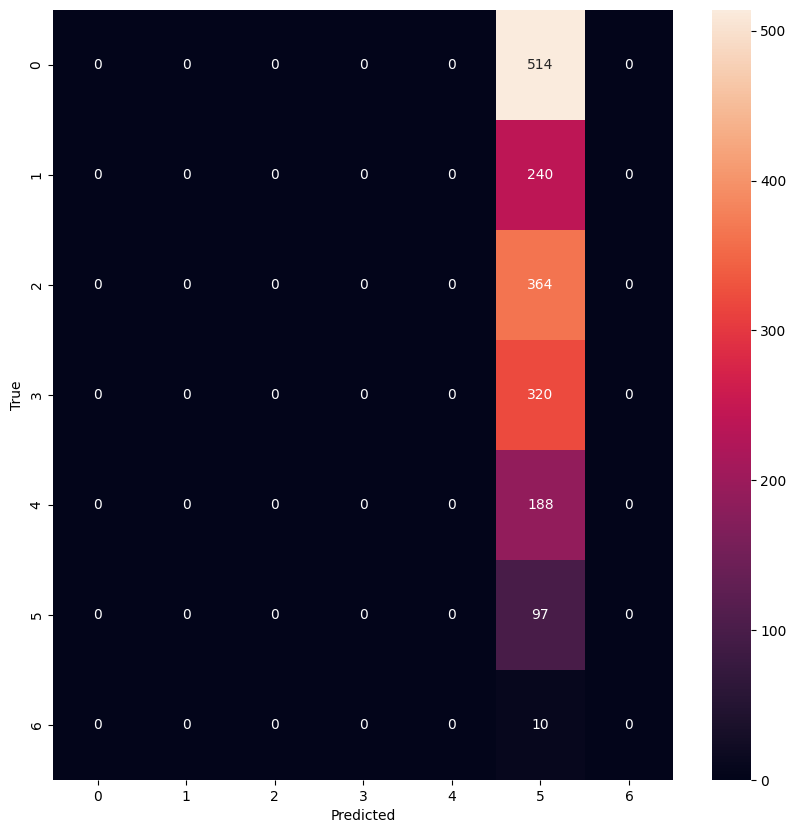

In [76]:
cm = confusion_matrix(test_generator.classes, preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
